# MFHT Grid Plot
plt.close('all')

In [66]:
import sqlite3
from IPython.display import display, Markdown, HTML
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle

from scipy.optimize import curve_fit

from pathlib import Path
import sys
sys.path.append('../stabilvol')
from utility.functions import stringify_threshold, numerify_threshold, format_mfht_directory, list_database_thresholds

ROOT = Path('../')
SELECTION_CRITERION = 'trapezoidal'
DATABASE = f'../data/processed/{SELECTION_CRITERION}_selection/stabilvol_filtered.sqlite'

MARKETS = ["UN", "UW", "LN", "JT"]
START_LEVELS = [3.0, 2.6, 2.2, 1.8, 1.4, 1., 0.6, 0.2]
DELTAS = [-0.2, -0.4, -0.8, -1.0]
LEVELS = {
    (round(start, 2), round(start+delta, 2)) for start in START_LEVELS for delta in DELTAS
}
LEVELS = {
    (start, round(start+delta, 2)) for start in START_LEVELS for delta in DELTAS
}
LEVELS = sorted(LEVELS)

VOL_LIMIT= 100  # Change this will change all the pickle files, remember to re-generate them
TAU_MAX = 30

FILE_DIR = ROOT / format_mfht_directory(SELECTION_CRITERION, VOL_LIMIT)
if not FILE_DIR.exists():
    display(HTML(f"<span style='color:red; font-size=24px;font-weight:bold'>WARNING: {FILE_DIR} do not exists.</span>"))
    display(HTML(f"<span>Creating directory</span>"))
    FILE_DIR.mkdir(parents=True, exist_ok=True)
else:
    print(f"Saving files in {FILE_DIR}")

len(LEVELS)

Saving files in ..\data\processed\trapezoidal_selection\vol100


32

## What Thresholds we have?

In [67]:
# Connect to the SQLite database
conn = sqlite3.connect(DATABASE)
cur = conn.cursor()

cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
# Fetch all table names
tables = cur.fetchall()
# Print the table names
def extract_threshold(table_names):
    thresholds = []
    for table in table_names:
        # Extract the threshold from the table name
        parts = table.replace('p', '.').replace('m', '-').split('_')
        # print(np.array(float(parts[1]), float(parts[2])))
        t1 = round(float(parts[1]), 2)
        t2 = round(float(parts[2]), 2)
        thresholds.append(np.array([t1, t2]))
    
    return np.array(thresholds)

thresholds = extract_threshold([table[0] for table in tables])
db_starts = thresholds[:, 0]
db_ends = thresholds[:, 1]
db_deltas = np.round(db_ends - db_starts, 2)
# print(f"Starts: {db_starts}\nEnds: {db_deltas}")
_ = list_database_thresholds(DATABASE)

Start Threshold 	     End Thresholds      
       -4.0     	  -8.0   -6.0   -5.0   -4.5   -3.5   -3.0   -2.0    0.0 
       -3.5     	  -4.0   -3.0 
       -3.0     	  -5.0   -4.0   -3.8   -3.6   -3.5   -3.4   -3.2   -2.8   -2.6   -2.5   -2.4   -2.2   -2.0   -1.0 
       -2.8     	  -3.8   -3.6   -3.4   -3.2   -3.0   -2.6   -2.4   -2.2   -2.0   -1.8 
       -2.6     	  -3.6   -3.4   -3.2   -3.0   -2.8   -2.4   -2.2   -2.0   -1.8   -1.6 
       -2.5     	  -3.0   -2.0 
       -2.4     	  -3.4   -3.2   -3.0   -2.8   -2.6   -2.2   -2.0   -1.8   -1.6   -1.4 
       -2.2     	  -3.2   -3.0   -2.8   -2.6   -2.4   -2.0   -1.8   -1.6   -1.4   -1.2 
       -2.0     	  -6.0   -4.0   -3.0   -2.8   -2.6   -2.5   -2.4   -2.2   -1.8   -1.6   -1.5   -1.4   -1.2   -1.0    0.0    2.0 
       -1.8     	  -2.8   -2.6   -2.4   -2.2   -2.0   -1.6   -1.4   -1.2   -1.0   -0.8 
       -1.6     	  -2.6   -2.4   -2.2   -2.0   -1.8   -1.4   -1.2   -1.0   -0.8   -0.6 
       -1.5     	  -2.0   -1.0 
       -1.4  

In [68]:
start_date = '2010-01-01'
end_date = '2022-07-01'
t1_string = "m2p0"
t2_string = "m1p5"
vol_limit = 0.5
market = "UN"
# Write the SQL query
query = f'''
SELECT *
FROM stabilvol_{t1_string}_{t2_string}
WHERE Volatility < {vol_limit} 
AND Market = "{market}"
AND start > "{start_date}"
AND end < "{end_date}"
'''
df1 = pd.read_sql_query(query, conn)
print(f"Max FHT: {df1['FHT'].max()}")
print(df1.head())
# df['FHT'].plot(kind='hist', bins=50, alpha=0.5, color='blue', label='FHT', figsize=(12, 4))

Max FHT: 30
   Volatility  FHT       start         end Market
0    0.015084    4  2010-01-25  2010-01-29     UN
1    0.015908    3  2010-02-01  2010-02-04     UN
2    0.012530    9  2010-02-05  2010-02-22     UN
3    0.012170   17  2010-02-23  2010-03-18     UN
4    0.019465    4  2010-03-19  2010-03-25     UN


In [69]:
start_date = '2010-01-01'
end_date = '2022-07-01'
t1_string = "2p0"
t2_string = "1p5"
vol_limit = 0.5
market = "UN"
# Write the SQL query
query = f'''
SELECT *
FROM stabilvol_{t1_string}_{t2_string}
WHERE Volatility < {vol_limit} 
AND Market = "{market}"
AND start > "{start_date}"
AND end < "{end_date}"    
AND FHT <= "{TAU_MAX}"
'''
df2 = pd.read_sql_query(query, conn)
print(f"Max FHT: {df2['FHT'].max()}")
print(df2.head())
# df2['FHT'].plot(kind='hist', bins=50, alpha=0.5, color='blue', label='FHT', figsize=(12, 4))

Max FHT: 30
   Volatility  FHT       start         end Market
0    0.028206    4  2010-06-04  2010-06-10     UN
1    0.016104   16  2010-06-11  2010-07-07     UN
2    0.018017    8  2010-07-08  2010-07-20     UN
3    0.017279   30  2010-07-21  2010-09-01     UN
4    0.011483   16  2011-02-01  2011-02-25     UN


## Binning process
This produces MFHT vs Volatility series from FHT data

In [70]:
def select_bins(df, max_n=1000):

    def error_on_the_mean(values):
        return np.std(values)/np.sqrt(len(values))

    nbins = 50
    
    while True:
        # Use qcut to bin 'Volatility' values
        df['Bins'] = pd.qcut(df['Volatility'], nbins, duplicates='drop')
        bin_count = df.groupby('Bins', observed=False)['FHT'].count()
        # Group by the bins and calculate the mean and standard error of 'value'
        grouped = df.groupby('Bins', observed=False)['FHT'].agg(['mean', error_on_the_mean, 'size'])
        count = grouped['size'].min()
        
        if count < max_n or nbins > 1000:
            break
        else:
            nbins += 50
    return grouped, bin_count


def query_binned_data(market: str, t1_string: str, t2_string: str, vol_limit: float):
    grouped_data = None
    nbins = 0
    bin_count = 0
    try:            
        # Write the SQL query
        query = f'''
        SELECT *
        FROM stabilvol_{t1_string}_{t2_string}
        WHERE Volatility < {vol_limit} 
        AND Market = "{market}"
        AND FHT < "{TAU_MAX}"
        '''
        # Load the FHT data from the database
        df = pd.read_sql_query(query, conn)
    except pd.errors.DatabaseError:
        raise ValueError(f'No data for market {market} with thresholds {t1_string}-{t2_string}')
    else:
        grouped_data, bin_count = select_bins(df)
    return grouped_data, bin_count


def bin_fht(market, regenerate=False):
    bin_counts = {}
    pbar = tqdm(LEVELS, desc=f'Processing {market}')
    for t1, t2 in pbar:
        bin_count = 0
        # Create the strings for the threshold values
        t1_string = stringify_threshold(t1)
        t2_string = stringify_threshold(t2)
        # Filename for the MFHT data
        filename = FILE_DIR / f'mfht_{market}_{t1_string}_{t2_string}.pkl'

        # Load the FHT dataframe from the database and bin it
        if regenerate or not filename.exists():
            try:
                grouped_data, bin_count = query_binned_data(market, t1_string, t2_string, VOL_LIMIT)
            except ValueError as e:
                print(f'Error in query: {e}')
                continue
            else:
                grouped_data.to_pickle(filename)
                pbar.set_postfix_str(f'Saved to {filename}')
        else:
            # Load the binned data from the pickle file
            grouped_data = pd.read_pickle(filename)
            pbar.set_postfix_str(f'Loaded from {filename}')

        bin_counts[(t1, t2)] = bin_count
            
    return bin_counts


def load_mfht(market, t1, t2):
    if not isinstance(t1, str):
        t1 = stringify_threshold(t1)
    if not isinstance(t2, str):
        t2 = stringify_threshold(t2)

    filename = f'mfht_{market}_{t1}_{t2}.pkl'
    try:
        df = pd.read_pickle(FILE_DIR / filename)
    except FileNotFoundError as e:
        print(f"File '{FILE_DIR / filename}' not found")
        raise ValueError(f"File {filename} not found")

    return df

In [71]:
# MFHT series should be already generated by stabilvol\bin_fht.py
# The bin_counts file keep track of experiments analyzed 
# and the number of FHT data points in each bin
mfht_outputs_file = ROOT / format_mfht_directory(SELECTION_CRITERION, VOL_LIMIT) / 'bin_counts.pkl'
if mfht_outputs_file.exists():
    with open(mfht_outputs_file, 'rb') as f:
        bin_counts = pickle.load(f)
else:
    bin_counts = {}
    for market in ["UN", "UW", "LN", "JT"]:
        bin_counts[market] = bin_fht(market, regenerate=False)

In [72]:
filename = list(FILE_DIR.iterdir())[1]
# Load the MFHT data from the database
df = pd.read_pickle(filename)
print(df.describe())
df.head()

              mean  error_on_the_mean           size
count  1022.000000        1022.000000    1022.000000
mean      3.332823           0.025607    4990.796477
std       0.389149           0.004960    4256.876804
min       2.058872           0.003712    3402.000000
25%       3.157456           0.023842    4856.000000
50%       3.445902           0.027221    4858.000000
75%       3.621559           0.028694    4858.000000
max       3.879786           0.036725  140878.000000


,mean,error_on_the_mean,size
Bins,,,
"(-0.0001, 1.164e-06]",2.665796,0.004253,140878
"(1.164e-06, 2.778e-06]",2.058872,0.003712,4858
"(2.778e-06, 4.673e-06]",2.060956,0.003741,4856
"(4.673e-06, 7.164e-06]",2.068369,0.003979,4856
"(7.164e-06, 1.006e-05]",2.063401,0.003843,4858


## Plot Grid

In [73]:
import matplotlib.colors as mcolors

def desaturate_color(color, factor=0.5):
    # Convert RGB to HLS
    rgb = mcolors.to_rgb(color)
    h, s, v = mcolors.rgb_to_hsv(rgb)

    # Decrease the saturation by 50% to get a desaturated color
    return mcolors.hsv_to_rgb((h, s*factor, v))

def plot_mfht_grid(markets, plotsscale='', show=False, save=False, latex=False):
    plt.rcParams.update({'text.usetex': latex, 'font.family': 'serif'})
    
    if not isinstance(markets, list):
        markets = [markets]
    if plotsscale not in ['', 'log', 'logx', 'logy']:
        raise ValueError("plotsscale must be either '' or 'log'")
    
    market_data = pd.read_csv(ROOT / 'data/interim/market_returns_data.csv', index_col=0)
    
    n_rows = len(START_LEVELS)
    n_cols = len(DELTAS)
    
    # Create a grid of subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 18))
    
    # Flatten the array of axes
    axs = axs.flatten()
    
    # Iterate over the indices and axes
    for i, ((t1, t2), ax) in enumerate(zip(LEVELS, axs)):
        # Create the strings for the threshold values
        t1_string = stringify_threshold(t1)
        t2_string = stringify_threshold(t2)
        
        for market in markets:
            # Load the dataframe from the database if it exists
            filename = f'mfht_{market}_{t1_string}_{t2_string}.pkl'
            std = round(market_data.loc["Average Std", market], 3)
            try:
                df = pd.read_pickle(FILE_DIR / filename)
            except FileNotFoundError as e:
                print(f"File '{FILE_DIR / filename}' not found")
                continue
            else:
                
                x = df.index.categories.left.values
                y = df['mean'].values
                
                y_err = df['error_on_the_mean'].values
                
                line, = ax.plot(x, y, lw=1, label=f"{market} $(\\sigma={std})$" if i==0 else "")
                
                ax.fill_between(x, y - y_err, y + y_err, alpha=0.2)
            
            if plotsscale == 'logx':
                ax.set_xscale('log')
            elif plotsscale == 'logy':
                ax.set_yscale('log')
            elif plotsscale == 'log':
                ax.set_xscale('log')
                ax.set_yscale('log')
            
            # If this is the first column, set the y-label
            if i % n_cols == 0:
                ax.set_ylabel(f"$\\theta_i = {t1}$", fontsize=16)
            # Always set the title with the final threshold value
            ax.set_title(f"$\\theta_f = {t2}$", fontsize=16)
    
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.5)
    
    # Place a legend above the subplots
    legend = fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.008), ncol=4)
    
    # Increase the font size
    plt.setp(legend.get_texts(), fontsize=18)
    
    # Increase the linewidth
    plt.setp(legend.get_lines(), linewidth=3)
    
    marketsname = ''.join(markets)
    if save:
        fig.savefig(f'../visualization/mfhts/{marketsname}_FHT_threshold_{plotsscale}grid.png', bbox_inches='tight')
        fig.savefig(f'../visualization/mfhts/{marketsname}_FHT_threshold_{plotsscale}grid.pdf', bbox_inches='tight', transparent=True)

    if show:
        plt.show()
    else:
        return fig
    

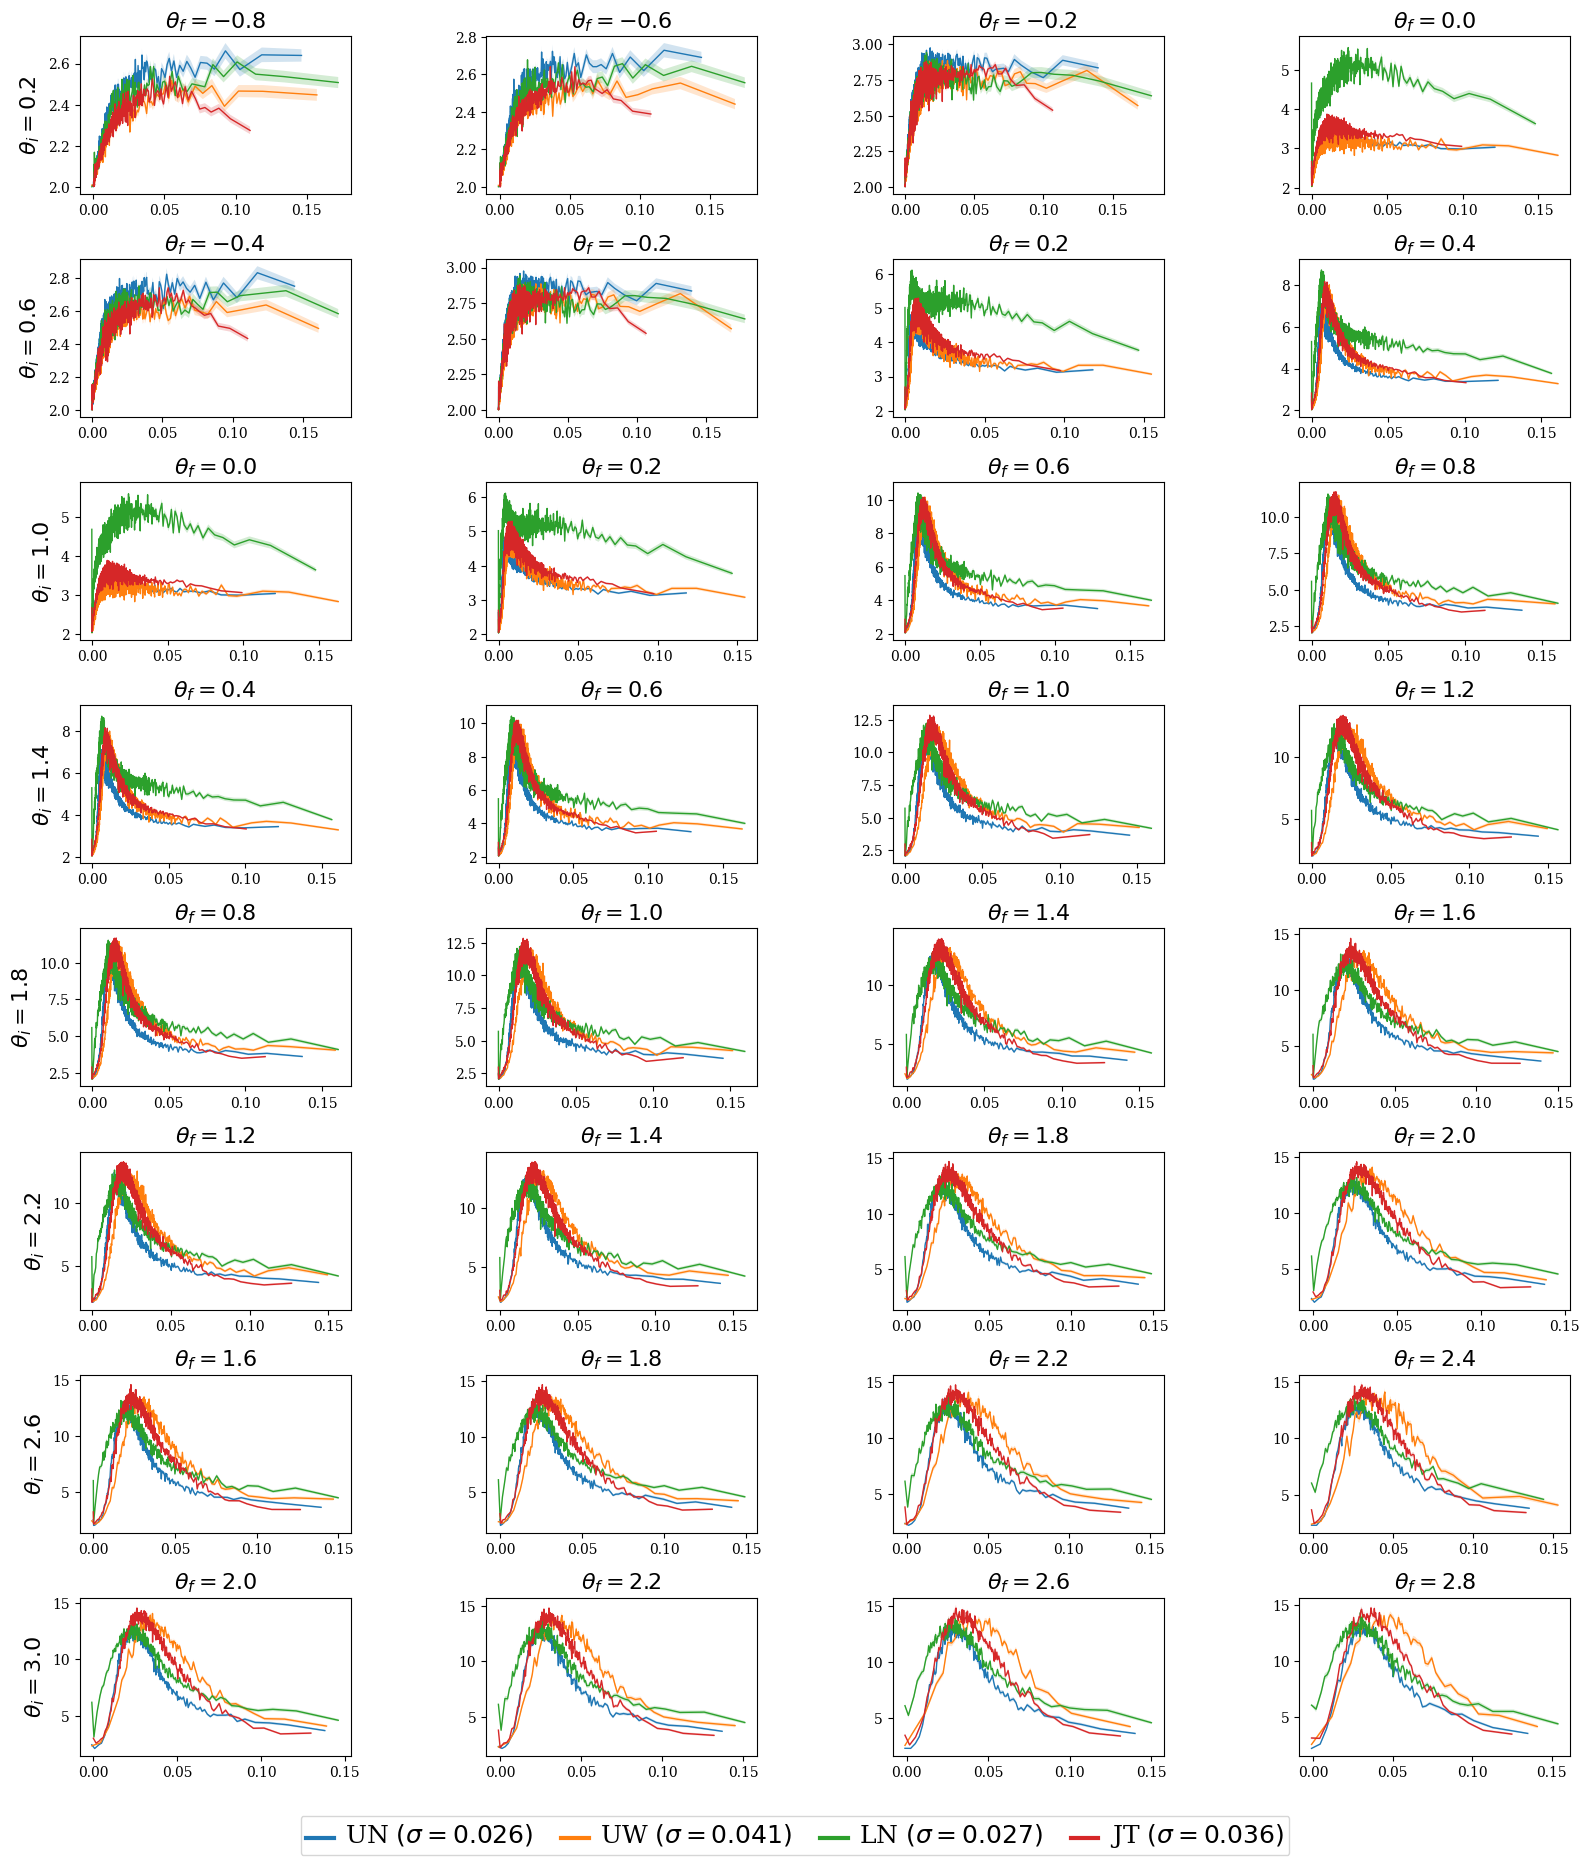

In [75]:
plt.close('all')
# plot_mfht_grid(["UN", "UW", "LN", "JT"], plotsscale='logx')
plot_mfht_grid(["UN", "UW", "LN", "JT"], plotsscale='', show=True)

## Look at the data
MFHTs are a collective behaviour of hitting times of returns. It is worth to see how many data points we have to calculate MFHT

In [76]:
levels = np.array([
    (-1.5, -2.0), (-2.0, -1.5), (2.0, 1.5), (1.5, 2.0),
    (2.0, 0.0), (-2.0, 0.0)
])

In [77]:
min(bin_counts['UW'][3.0, 4.0].values())

20

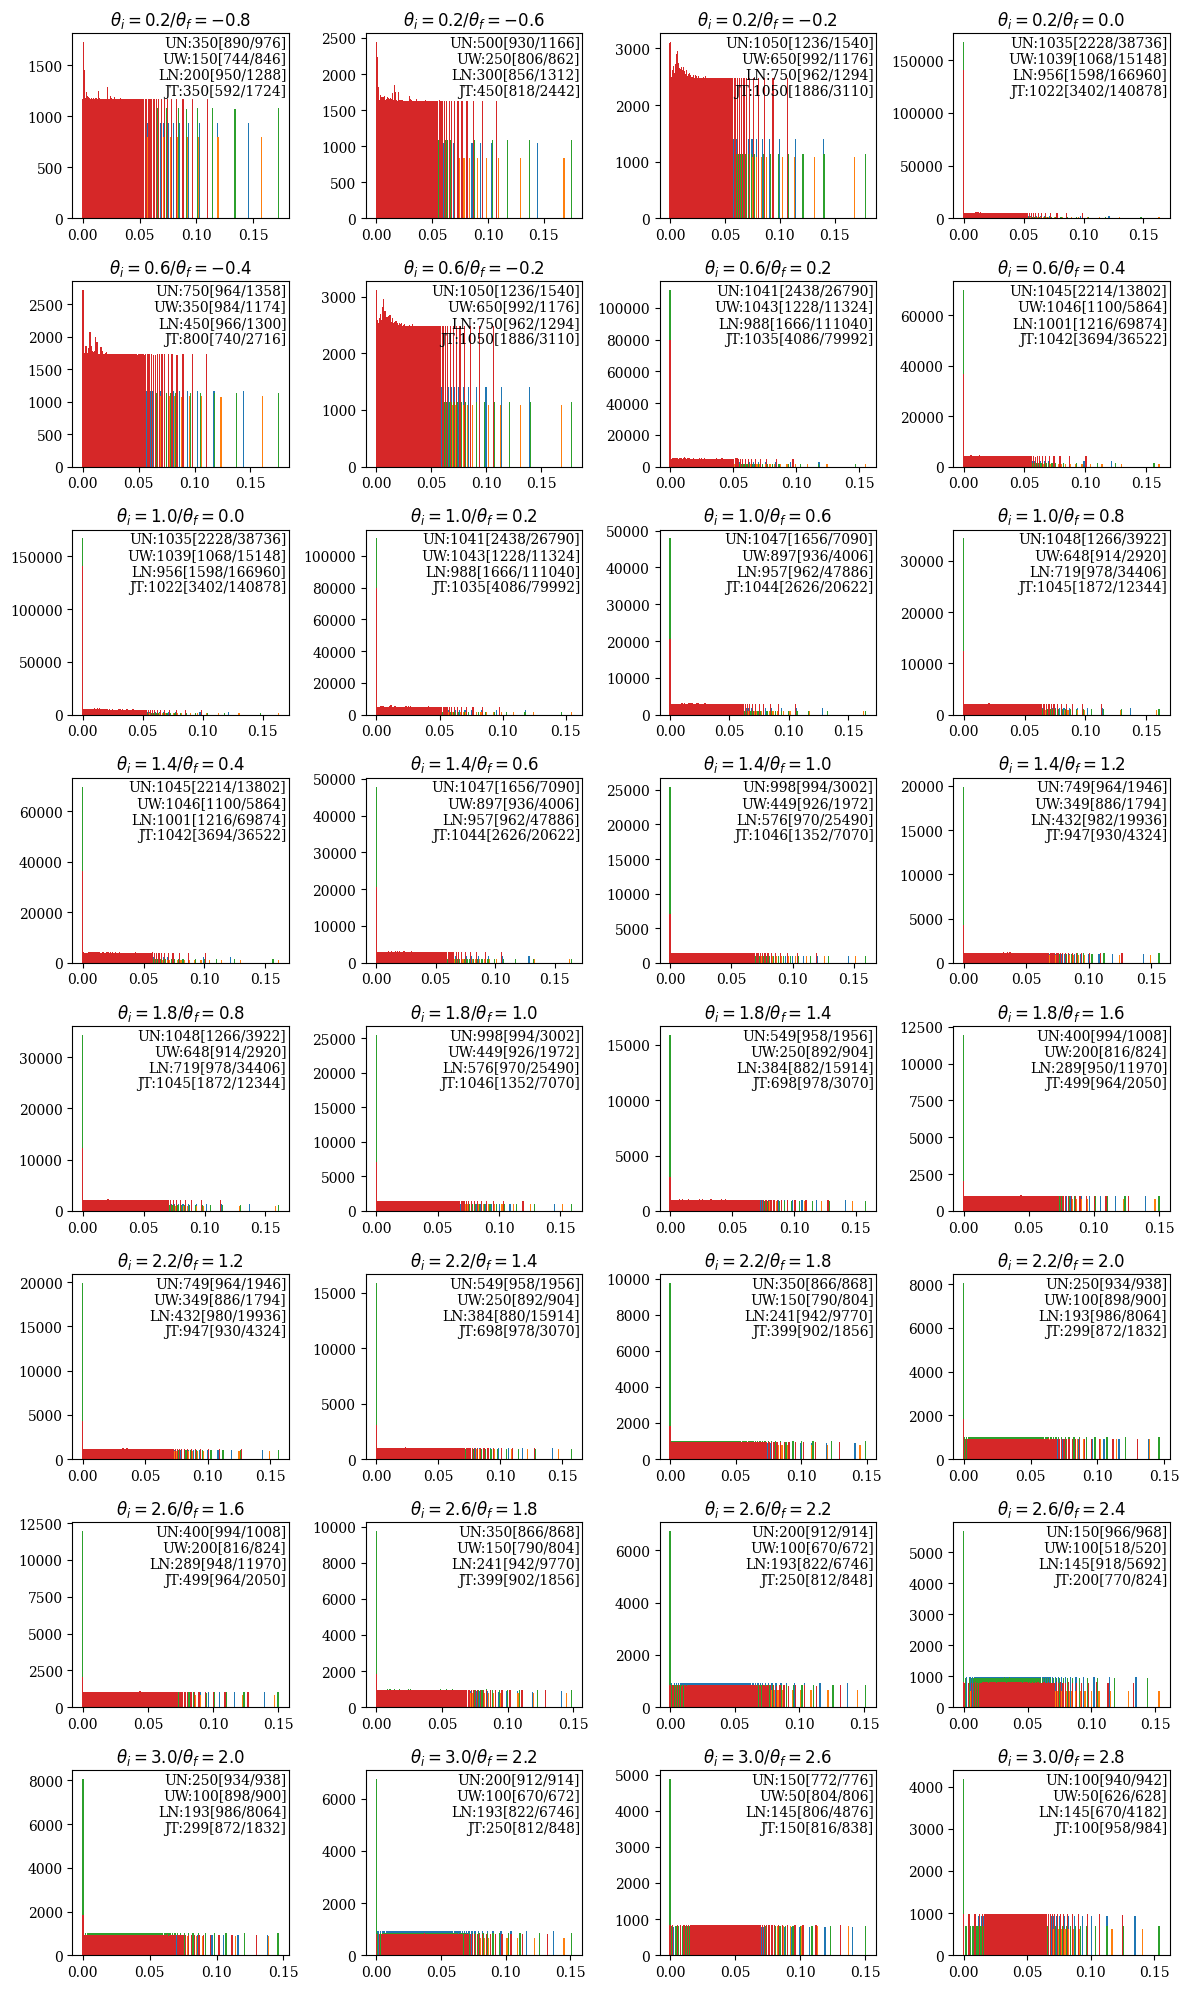

In [78]:
def plot_grid_info(markets, counts, levels=LEVELS, layout=None, bars=True):
    if layout is None:
        n_rows = len(levels)
        n_cols = 1
    else:
        n_rows, n_cols = layout

    # Create a grid of subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 20), layout='tight')

    # Flatten the array of axes
    axs = axs.flatten()

    for i, ((t1, t2), ax) in enumerate(zip(levels, axs)):
        strings = []
        width = 0.001
        for i, market in enumerate(MARKETS):
            count = counts[market].get((t1, t2), None)
            if count is None:
                continue
            n_bins = len(count.values())
            min_n = min(count.values())
            max_n = max(count.values())
            strings.append(f'{market}:{n_bins}[{min_n}/{max_n}]')
            if bars:
                x = np.array([c[0] if c[0] > 0 else 0 for c in count.keys()])
                heights = count.values()
                rects = ax.bar(x, heights, width, label=market)

        ax.text(0.99, 0.99, 
                f"{'\n'.join(strings)}", 
                ha='right', va='top', transform=ax.transAxes)
        ax.set_title(f"$\\theta_i= {t1} / \\theta_f = {t2}$")
        
    plt.show()
    return 

# It is better to do this in a subset of samples
# levels = [
#     (-1.5, -2.0), (-2.0, -1.5), (2.0, 1.5), (1.5, 2.0)
# ]
plot_grid_info(["UN", "UW", "LN", "JT"], bin_counts, LEVELS, bars=True,
               layout=(len(START_LEVELS), len(DELTAS)))

## Resistances
The previous plot may show resistances of the market of getting more infrequnetly and faster out of thresholds more distant from the central value 0

## Characterizing Curves
The nonmonotonic behaviour may be charcterized taking:
- Maximum values of FHT
- Average values of FHT
- Standard Deviation at maximum FHT

In [90]:
def get_avg_values(market):
    avg = {}
    # Iterate over the indices and axes
    for i, t1 in enumerate(START_LEVELS):
        for j, d in enumerate(DELTAS):
            # Create the strings for the threshold values
            t1_string = stringify_threshold(t1)
            t2_string = stringify_threshold(t1 + d)
            filename = f'mfht_{market}_{t1_string}_{t2_string}.pkl'

            # Load the dataframe from the database if it exists
            try:
                df = pd.read_pickle(FILE_DIR / filename)
            except FileNotFoundError as e:
                print(f"File '{filename}' not found")
                continue
            else:
                avg[(t1, t1+d)] = df['mean'].mean()
            
    # maxs = maxs.reshape((len(START_LEVELS), len(DELTAS)))
    return avg


def get_max_values(market, starts=START_LEVELS, deltas=DELTAS):
    maxs = {}
    # Iterate over the indices and axes
    for i, t1 in enumerate(starts):
        for j, d in enumerate(deltas):
            # Create the strings for the threshold values
            t1_string = stringify_threshold(t1)
            t2_string = stringify_threshold(t1 + d)
            filename = f'mfht_{market}_{t1_string}_{t2_string}.pkl'

            # Load the dataframe from the database if it exists
            try:
                df = pd.read_pickle(FILE_DIR / filename)
            except FileNotFoundError as e:
                print(f"File '{filename}' not found")
                continue
            else:
                maxs[(t1, t1+d)] = df['mean'].max()
            
    # maxs = maxs.reshape((len(START_LEVELS), len(DELTAS)))
    return maxs


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


def make_grid(data_dict):
    # Extract unique x and y values, sorted
    x_coords = sorted(set([k[0] for k in data_dict.keys()]))
    y_coords = sorted(set([k[1] for k in data_dict.keys()]), reverse=True)  # Reversed for proper orientation

    # Create grid
    grid = np.zeros((len(y_coords), len(x_coords)))

    # Map coordinates to indices
    x_map = {val: idx for idx, val in enumerate(x_coords)}
    y_map = {val: idx for idx, val in enumerate(y_coords)}

    # Fill grid
    for (x, y), val in data_dict.items():
        grid[y_map[y], x_map[x]] = val
    
    return grid


def add_annotations(ax, peaks, starts, deltas):
    for i, ti in enumerate(starts):
        for j, d in enumerate(deltas):
            text = ax.text(j, i, round(peaks[(ti, ti+d)],1), 
                           ha="center", va="center", color="white", fontsize=9)
    return text


def plot_mfht_peaks(market, peaks, starts, deltas, min_value, max_value, ax=None, annotations=True, latex=False, save=False):
    plt.rcParams.update({'text.usetex': latex, 'font.family': 'serif'})
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 18))
        
    ax.set_title(market, fontsize=18)
    values = np.array(list(peaks.values())).reshape(len(starts), len(deltas))
    im = ax.imshow(values, cmap='viridis', 
                   vmin=min_value, vmax=max_value,
                #    norm = mcolors.LogNorm(vmin=min_value, vmax=max_value)
                   )
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(deltas)), labels=deltas, fontsize=11, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_yticks(np.arange(len(starts)), labels=starts, fontsize=11)
    
    # Set the grid
    ax.set_xticks(np.arange(-.5, len(deltas), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(starts), 1), minor=True)
        
    # Remove the grid lines in the middle of the cells
    ax.grid(False)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
    
    # Loop over data dimensions and create text annotations.
    if annotations:
        annotations_text = add_annotations(ax, peaks, starts, deltas)
                    
    if ax is None:
        plt.show()
    else:
        return ax, im

{'UN': {(-3.0, -2.8): np.float64(12.775280898876405), (-3.0, -2.6): np.float64(13.105145413870247), (-3.0, -2.2): np.float64(12.80204081632653), (-3.0, -2.0): np.float64(12.943632567849686), (-2.6, -2.4): np.float64(13.052631578947368), (-2.6, -2.2): np.float64(12.80204081632653), (-2.6, -1.8): np.float64(12.786729857819905), (-2.6, -1.6): np.float64(12.74074074074074), (-2.2, -2.0): np.float64(12.943632567849686), (-2.2, -1.8000000000000003): np.float64(12.786729857819905), (-2.2, -1.4000000000000001): np.float64(12.491416309012875), (-2.2, -1.2000000000000002): np.float64(12.406438631790744), (-1.8, -1.6): np.float64(12.74074074074074), (-1.8, -1.4): np.float64(12.491416309012875), (-1.8, -1.0): np.float64(11.79441117764471), (-1.8, -0.8): np.float64(11.091666666666667), (-1.4, -1.2): np.float64(12.406438631790744), (-1.4, -0.9999999999999999): np.float64(11.79441117764471), (-1.4, -0.5999999999999999): np.float64(9.429782082324456), (-1.4, -0.3999999999999999): np.float64(7.72069597

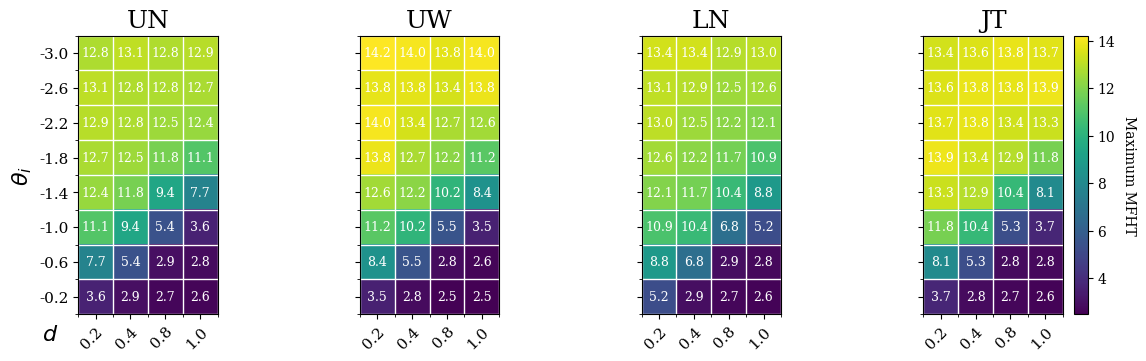

{'UN': {(3.0, 2.8): np.float64(13.11276595744681), (3.0, 2.6): np.float64(13.116279069767442), (3.0, 2.2): np.float64(13.520787746170678), (3.0, 2.0): np.float64(13.26226012793177), (2.6, 2.4): np.float64(13.215320910973086), (2.6, 2.2): np.float64(13.520787746170678), (2.6, 1.8): np.float64(13.07621247113164), (2.6, 1.6): np.float64(12.996007984031936), (2.2, 2.0): np.float64(13.26226012793177), (2.2, 1.8000000000000003): np.float64(13.07621247113164), (2.2, 1.4000000000000001): np.float64(12.674180327868852), (2.2, 1.2000000000000002): np.float64(12.48559670781893), (1.8, 1.6): np.float64(12.996007984031936), (1.8, 1.4): np.float64(12.674180327868852), (1.8, 1.0): np.float64(11.938), (1.8, 0.8): np.float64(10.681957186544343), (1.4, 1.2): np.float64(12.48559670781893), (1.4, 0.9999999999999999): np.float64(11.938), (1.4, 0.5999999999999999): np.float64(9.121896162528216), (1.4, 0.3999999999999999): np.float64(7.111599297012302), (1.0, 0.8): np.float64(10.681957186544343), (1.0, 0.6):

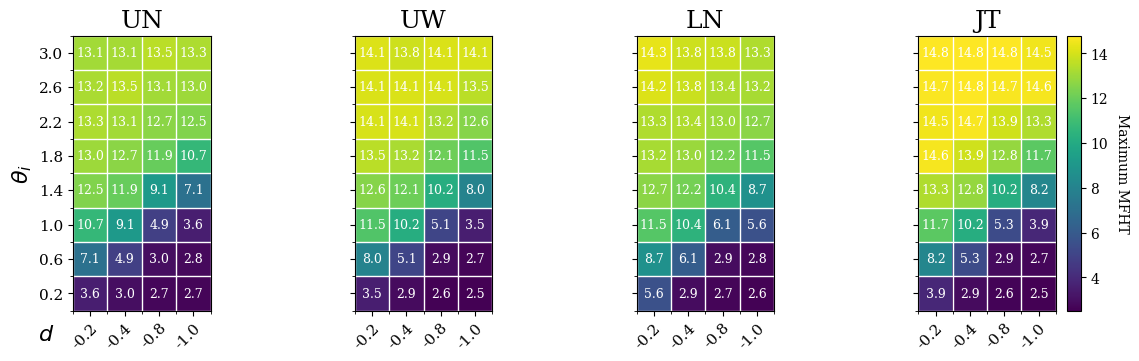

In [92]:
def plot_avg_comparison(show=True, save=False, latex=False):
    plt.rcParams.update({'text.usetex': latex, 'font.family': 'serif'})
    
    peaks = {market: get_avg_values(market) for market in ["UN", "UW", "LN", "JT"]}
    max_value, min_value = max(max(v.values()) for v in peaks.values()), min(min(v.values()) for v in peaks.values())
    print(max_value, min_value)

    fig, axs = plt.subplots(1, 4, figsize=(15, 3.5), sharey=True, layout='constrained')

    for market, ax in zip(MARKETS, axs.flatten()):
        ax, im = plot_mfht_peaks(market, peaks[market], min_value, max_value, ax, annotations=True)

    # Add the y-axis and x-axis labels
    axs[0].set_ylabel(r"$\theta_i$", fontsize=16)
    axs[0].set_xlabel(r"$d$", fontsize=16, x=-0.2, labelpad=-20)

    # Add a colorbar
    cbar = fig.colorbar(im, ax=axs.ravel().tolist(), pad=0.01)
    cbar.set_label('Maximum MFHT', rotation=270, labelpad=15)

    if save:
        fig.savefig(f'../visualization/mfhts/max_MFHT_comparison.png', bbox_inches='tight')
        fig.savefig(f'../visualization/mfhts/max_MFHT_comparison.pdf', bbox_inches='tight', transparent=True)

    if show:
        plt.show()

def plot_peaks_comparison(starts=START_LEVELS, deltas=DELTAS, show=True, save=False, latex=False):
    plt.rcParams.update({'text.usetex': latex, 'font.family': 'serif'})
    
    peaks = {market: get_max_values(market, starts, deltas) for market in ["UN", "UW", "LN", "JT"]}
    print(peaks)
    max_value, min_value = max(max(v.values()) for v in peaks.values()), min(min(v.values()) for v in peaks.values())
    print(max_value, min_value)

    fig, axs = plt.subplots(1, 4, figsize=(12, 3.5), sharey=True, layout='constrained')

    for market, ax in zip(MARKETS, axs.flatten()):
        ax, im = plot_mfht_peaks(market, peaks[market], starts, deltas, min_value, max_value, ax, annotations=True)

    # Add the y-axis and x-axis labels
    axs[0].set_ylabel(r"$\theta_i$", fontsize=16)
    axs[0].set_xlabel(r"$d$", fontsize=16, x=-0.2, labelpad=-20)

    # Add a colorbar
    cbar = fig.colorbar(im, ax=axs.ravel().tolist(), pad=0.01)
    cbar.set_label('Maximum MFHT', rotation=270, labelpad=15)

    if save:
        fig.savefig(f'../visualization/mfhts/max_MFHT_comparison.png', bbox_inches='tight')
        fig.savefig(f'../visualization/mfhts/max_MFHT_comparison.pdf', bbox_inches='tight', transparent=True)

    if show:
        plt.show()

low_starts = [-3.0, -2.6, -2.2, -1.8, -1.4, -1., -0.6, -0.2]
rallies = [0.2, 0.4, 0.8, 1.0]
plot_peaks_comparison(starts=low_starts, deltas=rallies, show=True)
# plot_avg_comparison(show=True)
high_starts = [3.0, 2.6, 2.2, 1.8, 1.4, 1., 0.6, 0.2]
crashes = [-0.2, -0.4, -0.8, -1.0]
plot_peaks_comparison(starts=high_starts, deltas=crashes, show=True)

In [81]:
# peaks = {market: get_avg_values(market) for market in ["UN", "UW", "LN", "JT"]}
market='UN'
t1_string="m2p0"
t2_string="m1p0"
# root_folder = ROOT / f'data/processed/trapezoidal_selection/vol0{str(VOL_LIMIT).replace(".", "")}'
# filename = f'mfht_{market}_{t1_string}_{t2_string}{"_filtered" if FILTERED else ""}.pkl'
# try:
#     df = pd.read_pickle(root_folder / filename)
# except FileNotFoundError as e:
#     print(f"File '{root_folder / filename}' not found")
# Write the SQL query
query = f'''
SELECT *
FROM stabilvol_{t1_string}_{t2_string}
WHERE Volatility < {VOL_LIMIT} 
AND Market = "{market}"
AND start > "{start_date}"
AND end < "{end_date}"    
'''
df = pd.read_sql_query(query, conn)
df.tail()

,Volatility,FHT,start,end,Market
471083,0.018637,2,2022-04-27,2022-04-29,UN
471084,0.016307,3,2022-05-02,2022-05-05,UN
471085,0.018442,8,2022-05-06,2022-05-18,UN
471086,0.015279,14,2022-05-19,2022-06-10,UN
471087,0.024559,3,2022-06-13,2022-06-16,UN


In [82]:
market='UN'
t1_string="m2p0"
t2_string="m1p5"
root_folder = ROOT / f'data/processed/trapezoidal_selection/vol0{str(VOL_LIMIT).replace(".", "")}'
filename = f'mfht_{market}_{t1_string}_{t2_string}.pkl'
# try:
#     df = pd.read_pickle(root_folder / filename)
# except FileNotFoundError as e:
#     print(f"File '{root_folder / filename}' not found")
query = f'''
SELECT *
FROM stabilvol_{t1_string}_{t2_string}
WHERE Volatility < {VOL_LIMIT} 
AND Market = "{market}"
AND start > "{start_date}"
AND end < "{end_date}"    
'''
df = pd.read_sql_query(query, conn)
df.tail()

,Volatility,FHT,start,end,Market
210745,0.022925,9,2021-01-27,2021-02-09,UN
210746,0.014897,14,2021-02-10,2021-03-04,UN
210747,0.016212,27,2021-09-22,2021-10-29,UN
210748,0.021200,15,2022-04-27,2022-05-18,UN
210749,0.018958,18,2022-05-19,2022-06-16,UN


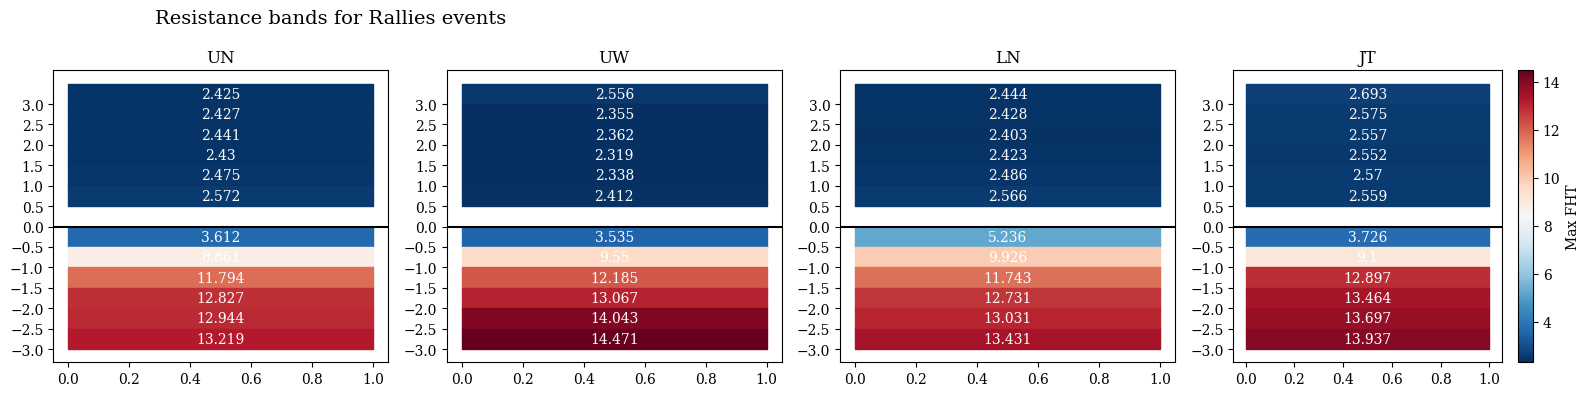

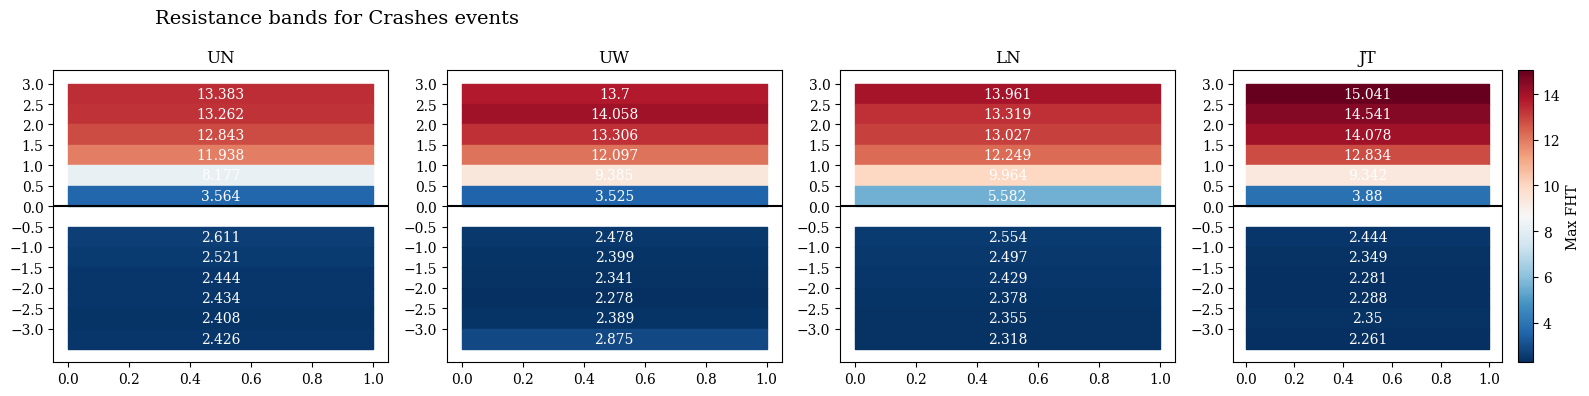

In [45]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


def create_colormap(min_value, max_value):
    # Create colormap
    cmap = plt.cm.RdBu_r
    norm = Normalize(vmin=min_value, vmax=max_value)

    return cmap, norm


def add_colorbar(fig, cmap, norm, ax):
    
    # Add colorbar
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Max FHT')


def plot_bands(ax, market_peaks, thresholds, cmap, norm):
    for t1, t2 in thresholds:
        
        max_value = market_peaks[(t1, t2)]
        color = cmap(norm(max_value))
        ax.text(0.5, (t1+t2)/2, f'{round(max_value, 3)}', va='center', ha='center', c='w')
        ax.fill_between([0, 1], t1, t2, alpha=1, color=color)


def make_banned_figure(t1s, t2s, event):
    
    peaks = {market: 
             {(t1, t2): load_mfht(market, t1, t2)['mean'].max() for t1, t2 in zip(t1s, t2s)} 
             for market in ["UN", "UW", "LN", "JT"]}
    max_value = max(max(v for v in t1t2.values()) for t1t2 in peaks.values())
    min_value = min(min(v for v in t1t2.values()) for t1t2 in peaks.values())

    fig, axs = plt.subplots(1, len(MARKETS), figsize=(16, 4), layout='tight')
    fig.suptitle(f'Resistance bands for {event.title()} events', x=0.1, ha='left', fontsize=14)
    
    cmap, norm = create_colormap(min_value, max_value)
    axs = axs.flatten()

    for i, market in enumerate(MARKETS):
        ax = axs[i]
        ax.axhline(y=0, c='k')
        ax.set_yticks(np.linspace(-3, 3, 13))
        ax.set_title(market)
        plot_bands(ax, peaks[market], zip(t1s, t2s), cmap, norm)

    add_colorbar(fig, cmap, norm, axs[-1])
    return fig, axs


def plot_bands_for_event(event, show=False, save=False):
    if event == 'crashes':
        d = -0.5
    elif event == 'rallies':
        d = 0.5
    elif event == 'mixed':
        d = [0.5, 0.5, 0.5, -0.5, -0.5, -0.5]
    
    t1s = np.array([3.0, 2.5, 2.0, 1.5, 1.0, 0.5, -0.5, -1.0, -1.5, -2.0, -2.5, -3.0])
    t2s = t1s + d

    fig, axs = make_banned_figure(t1s, t2s, event)

    if save:
        fig.savefig(f'../visualization/mfhts/max_MFHT_bands_{event}.png', bbox_inches='tight')
        fig.savefig(f'../visualization/mfhts/max_MFHT_bands_{event}.pdf', bbox_inches='tight', transparent=True)

    if show:
        plt.show()
    else:
        return fig
    

plot_bands_for_event("rallies", show=True, save=True)
plot_bands_for_event("crashes", show=True, save=True)

In [27]:
bin_counts["UN"][(2.5, 3.0)]

{(np.float64(-0.001), np.float64(0.000751)): 236,
 (np.float64(0.000751), np.float64(0.00164)): 234,
 (np.float64(0.00164), np.float64(0.00241)): 236,
 (np.float64(0.00241), np.float64(0.00328)): 234,
 (np.float64(0.00328), np.float64(0.00404)): 234,
 (np.float64(0.00404), np.float64(0.00485)): 236,
 (np.float64(0.00485), np.float64(0.00561)): 234,
 (np.float64(0.00561), np.float64(0.00639)): 234,
 (np.float64(0.00639), np.float64(0.00716)): 236,
 (np.float64(0.00716), np.float64(0.00807)): 234,
 (np.float64(0.00807), np.float64(0.00909)): 234,
 (np.float64(0.00909), np.float64(0.00991)): 236,
 (np.float64(0.00991), np.float64(0.0109)): 234,
 (np.float64(0.0109), np.float64(0.012)): 234,
 (np.float64(0.012), np.float64(0.0131)): 236,
 (np.float64(0.0131), np.float64(0.0142)): 234,
 (np.float64(0.0142), np.float64(0.0155)): 234,
 (np.float64(0.0155), np.float64(0.0168)): 236,
 (np.float64(0.0168), np.float64(0.0181)): 234,
 (np.float64(0.0181), np.float64(0.0192)): 236,
 (np.float64(0.0